# ATW relaxation notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy

# Global constants
f = 1e-4      # [s-1]
g = 9.81      # [m s-2]

%matplotlib inline
plt.rcParams['font.size'] = 14
warnings.simplefilter('ignore')

### Analytical solution

Start with the linearized, steady state shallow water equations with linear friction and longshore windstress. Assume cross-shore geostrophic balance.

\begin{align}
f\mathbf{k}\times\mathbf{u} & = -g\nabla\eta + \frac{1}{h}\left(\tau_y - \mu v\right)\hat{\jmath} \tag{1a} \\
0 & = \nabla\cdot h\mathbf{u} \tag{1b}
\end{align}

Taking the curl of (1a) and solving for $\eta$ gives the the Arrested Topography Wave (ATW) of Csanady (1978 *JPO*). I have oriented the problem to $x\to-\infty$ offshore such that $\frac{\partial h}{\partial x} = -s$.

$$\frac{\partial^2\eta}{\partial x^2} - \frac{1}{\kappa}\frac{\partial\eta}{\partial y} = 0, \hspace{0.5cm} \frac{1}{\kappa} = \frac{fs}{\mu}\tag{2}$$

The coastal boundary condition (obtained from 1a) requires $u \to 0$ and $h \to 0$

$$\frac{\partial\eta}{\partial x}(0, y) = \frac{\tau_yf}{\mu g} = q_0 \tag{3}$$

Equation (2) is analogous to a constant heat flux boundary condition. The solution is given by Carslaw and Jaeger 1959 (p. 112)

$$\eta(x, y) = \frac{\kappa q_0y}{L} + q_0L\left\{\frac{3(x + L)^2 - L^2}{6L^2} - \frac{2}{\pi^2}\sum_{n=1}^\infty\frac{(-1)^n}{n^2}\exp\left(\frac{-\kappa n^2\pi^2y}{L^2}\right)\cos\left(\frac{n\pi(x + L)}{L}\right)\right\} \tag{4}$$

which, as $y\to\infty$, reduces to

$$\eta(x, y) = \frac{\kappa q_0y}{L} + q_0L\frac{3(x + L)^2 - L^2}{6L^2} \tag{5}$$

Calculate $\eta$ according to equation (5)

In [4]:
def calc_eta(x, y, L, kappa, q_0):
    """Calculate eta according to equation 5
    """
    
    return kappa * q_0 * y / L + q_0 * L * (3 * (x + L)**2 - L**2) / (6 * L**2)

Find $\eta$ given problem parameters

In [14]:
# Constants
L = 1e3        # Slope width [m]
tau_y = -1e-4  # Kinematic wind stress [m2 s-2]
mu = 1e-2      # Linear friction coefficient [s-1]
s = 1          # Shelf slope [dimensionless]

# Terms (heat equation analogues)
kappa = mu / (f * s)        # 'Diffusivity' of eta
q_0 = tau_y * f / (mu * g)  # 'Flux' of eta through boundary

# Coordinates
dL = L * 1e-2
xi = np.arange(-L, 0, dL)
yi = np.arange(0, L, dL)
x, y = np.meshgrid(xi, yi)

# Solution
eta = calc_eta(x, y, L, kappa, q_0)

Plot $\eta$ solution

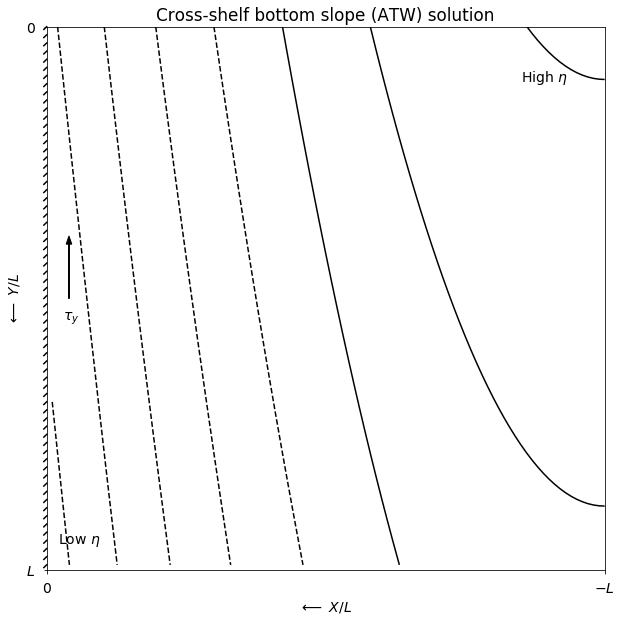

In [15]:
# Plot eta
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.contour(xi/L, yi/L, eta, colors='k')
for tick in np.arange(0, 1, 0.015):
    ax.plot([0, 0.005], [tick, tick+0.005], 'k-', clip_on=False)
ax.set_xlabel('$\longleftarrow$ $X/L$')
ax.set_ylabel('$\longleftarrow$ $Y/L$')
ax.xaxis.set_ticks([-1, 0])
ax.yaxis.set_ticks([0, 1])
ax.xaxis.set_ticklabels(['$-L$', 0])
ax.yaxis.set_ticklabels([0, '$L$'])
ax.tick_params(direction='out', pad=8)
ax.set_xlim([0, -1])
ax.set_ylim([1, 0])
ax.text(0.02, 0.05, 'Low $\eta$', transform=ax.transAxes)
ax.text(0.85, 0.9, 'High $\eta$', transform=ax.transAxes)
ax.text(0.03, 0.46, '$\\tau_y$', transform=ax.transAxes)
ax.arrow(0.04, 0.5, 0, 0.1, transform=ax.transAxes, head_width=0.01, facecolor='k')
ax.set_title('Cross-shelf bottom slope (ATW) solution')

plt.show()

### Relaxation solution

Three schemes:

Centered difference

$$r_{i, j}^{(n)} = \frac{\eta_{i, j+1}^{(n)} - \eta_{i, j-1}^{(n)}}{2\Delta y} - \kappa\frac{\eta_{i+1, j}^{(n)} - 2\eta_{i, j}^{(n)} + \eta_{i-1, j}^{(n)}}{\Delta x^2}$$

$$\eta_{i, j}^{(n+1)} = \eta_{i, j}^{(n)} - \frac{\mu\Delta x^2}{2\kappa}r_{i, j}^{(n)}$$

Upstream Euler

$$r_{i, j}^{(n)} = \frac{\eta_{i, j+1}^{(n)} - \eta_{i, j}^{(n)}}{\Delta y} - \kappa\frac{\eta_{i+1, j}^{(n)} - 2\eta_{i, j}^{(n)} + \eta_{i-1, j}^{(n)}}{\Delta x^2}$$

$$\eta_{i, j}^{(n+1)} = \eta_{i, j}^{(n)} - \frac{\mu}{\left(\frac{2\kappa}{\Delta x} - 1\right)}r_{i, j}^{(n)}$$

Downstream Euler

$$r_{i, j}^{(n)} = \frac{\eta_{i, j}^{(n)} - \eta_{i, j-1}^{(n)}}{\Delta y} - \kappa\frac{\eta_{i+1, j}^{(n)} - 2\eta_{i, j}^{(n)} + \eta_{i-1, j}^{(n)}}{\Delta x^2}$$

$$\eta_{i, j}^{(n+1)} = \eta_{i, j}^{(n)} - \frac{\mu}{\left(\frac{2\kappa}{\Delta x} + 1\right)}r_{i, j}^{(n)}$$

Only the downstream Euler is stable.

Find $\eta$ by relaxation

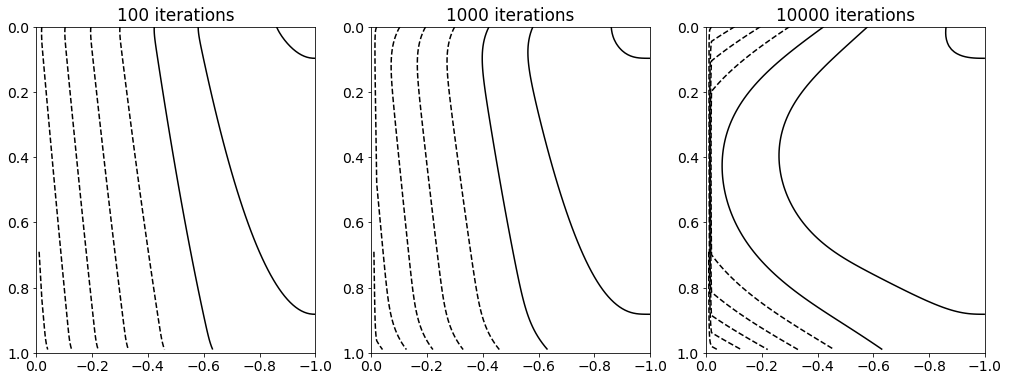

In [18]:
# Find phi by relaxation

# Parameters
M = eta.shape[0] # matrix size
mu = 1           # SOR convergence parameter
TOL = 1e-4       # Convergence tolerance

# Allocate arrays
eta_next = deepcopy(eta)
res = np.zeros(eta.shape)

# Make figure array
fig, axs = plt.subplots(1, 3, figsize=(17, 6))

# Plot 3 max iterations (N)
for ax, N in zip(axs, [100, 1000, 10000]):

    # Reset eta (equation 37)
    eta = kappa * q_0 * y / L + q_0 * L * (3 * (x + L)**2 - L**2) / (6 * L**2)
    
    # Relaxation loop
    for n in range(N):
        for i in range(1, M-1): # Longshore step
            for j in range(1, M-1): # Cross-shore step
                #Downstream Euler
                res[i, j] = (eta[i, j] - eta[i, j-1]) / dL - kappa * (eta[i+1, j] - 2 * eta[i, j] + eta[i-1, j]) / dL**2
                eta_next[i, j] = eta[i, j] - mu / (2 * kappa / dL + 1) * res[i, j]
        eta = eta_next
        if dL**2 * np.max(abs(res)) / np.max(abs(eta)) < TOL:
            break

    # Plot results
    ax.contour(xi/L, yi/L, eta, colors='k')
    ax.set_xlim([0, -1])
    ax.set_ylim([1, 0])
    ax.set_title(f'{N} iterations')